# Import Libraries

In [5]:
# !pip install transformers[torch]
# !pip install accelerate -U

# !pip install datasets -q
# !pip install seqeval -q
# !pip install tokenizers -q
# !pip install transformers -q


# System and files 
import zipfile
import os
from IPython.display import FileLink

# Data processing
import numpy as np
import re
import pandas as pd
import ast
import json

import tokenizers
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import torch
from torch.utils.data import DataLoader
from datasets import Dataset, concatenate_datasets, load_metric
from sklearn.model_selection import train_test_split, KFold

# Visualization
import plotly.express as px
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

# Model
import transformers
from transformers import LineByLineTextDataset, DataCollatorForLanguageModeling, AutoModelForTokenClassification, DebertaForTokenClassification, DebertaTokenizer, DistilBertConfig, DistilBertForMaskedLM,DistilBertTokenizer, Trainer, TrainingArguments, AutoTokenizer, DataCollatorForTokenClassification, AdamW

# Token Classification
import seqeval

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Defined Functions

In [63]:
# Preprocess the input text
def preprocess_text(text):

    #Remove HTML tags
    text = re.sub(r'<[^>]+>', ' ', text)

    #Remove all the special characters
    text = re.sub(r'\W', ' ', text)

    #remove all single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)

    #Remove single characters from the start
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text)

    #Substituting multiple spaces with single space
    text = re.sub(r'\s+', ' ', text, flags=re.I)

    #Converting to Lowercase
    text = text.lower()

    return text


#
def match_sentence(sentence, paragraph, feature_num, labels):
    sentence_length = len(sentence)

    for i in range(len(paragraph) - sentence_length + 1):
        if paragraph[i:i + sentence_length] == sentence:
            labels[i] = feature_num
            labels[i+1:i + sentence_length] = [feature_num + 1]*(sentence_length - 1)

    return labels


#
def or_on_list(list1, list2):
  return [a or b for a, b in zip(list1, list2)]


#
def get_labels(pn_num_to_labels, pn_num):
    return pn_num_to_labels.get(pn_num, [])


# Save files to system
def zip_dir(directory = os.curdir, file_name = 'directory2.zip'):
    os.chdir(directory)
    zip_ref = zipfile.ZipFile(file_name, mode='w')
    for folder, _, files in os.walk(directory):
        for file in files:
            if file_name in file:
                pass
            else:
                zip_ref.write(os.path.join(folder, file))

    return FileLink(file_name)

# Load Data

In [ ]:
# Fetch data from kaggle for google collab
# !pip install -q opendatasets

# import opendatasets as od

# od.download('https://www.kaggle.com/competitions/nbme-score-clinical-patient-notes/data')

In [9]:
# Read data

train_df = pd.read_csv('/kaggle/input/nbme-score-clinical-patient-notes/train.csv')

features_df = pd.read_csv('/kaggle/input/nbme-score-clinical-patient-notes/features.csv')
patient_notes_df = pd.read_csv('/kaggle/input/nbme-score-clinical-patient-notes/patient_notes.csv')

test_df = pd.read_csv('/kaggle/input/nbme-score-clinical-patient-notes/test.csv')
sample_submission_df = pd.read_csv('/kaggle/input/nbme-score-clinical-patient-notes/sample_submission.csv')

# Explore Data


## Training Data


In [10]:
train_df

,id,case_num,pn_num,feature_num,annotation,location
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724']
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693']
2,00016_002,0,16,2,['chest pressure'],['203 217']
3,00016_003,0,16,3,"['intermittent episodes', 'episode']","['70 91', '176 183']"
4,00016_004,0,16,4,['felt as if he were going to pass out'],['222 258']
...,...,...,...,...,...,...
14295,95333_912,9,95333,912,[],[]
14296,95333_913,9,95333,913,[],[]
14297,95333_914,9,95333,914,['photobia'],['274 282']
14298,95333_915,9,95333,915,['no sick contacts'],['421 437']


In [11]:
train_df['annotation'].value_counts()

annotation
[]                                          4399
['F']                                        304
['female']                                   217
['M']                                        127
['nausea']                                   105
                                            ... 
['stools (no noticeable blood']                1
['also occurs at night']                       1
['drinks couple beers per week']               1
['progressively worse', 'occurs 2x/day']       1
['photobia']                                   1
Name: count, Length: 5201, dtype: int64

In [12]:
# some different feature_numbers correspond to the same annotations.

train_df[train_df['annotation'] == "['F']" ]['feature_num'].unique()

array([112, 208, 407, 501, 700, 802, 913])

**Notes:**

- Each feature_number corresponds to a certain annotation (one sentence that makes the text belong to a certain class) that was found in the text.
- One text can have multiple different annotation. Thus, one text can belong to multiple classes.
- Each annotation is found in a certain location in the text that is decribed by chararcters numbers `[start end]` in the 'location' column.

**To fix:**
- Data Shows many empty rows
- Some different feature_numbers correspond to the same annotation.


## Features

In [13]:
features_df

,feature_num,case_num,feature_text
0,0,0,Family-history-of-MI-OR-Family-history-of-myoc...
1,1,0,Family-history-of-thyroid-disorder
2,2,0,Chest-pressure
3,3,0,Intermittent-symptoms
4,4,0,Lightheaded
...,...,...,...
138,912,9,Family-history-of-migraines
139,913,9,Female
140,914,9,Photophobia
141,915,9,No-known-illness-contacts


In [14]:
features_df['feature_num'].unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
       100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
       200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212,
       213, 214, 215, 216, 300, 301, 302, 303, 304, 305, 306, 307, 308,
       309, 310, 311, 312, 313, 314, 315, 400, 401, 402, 403, 404, 405,
       406, 407, 408, 409, 500, 501, 502, 503, 504, 505, 506, 507, 508,
       509, 510, 511, 512, 513, 514, 515, 516, 517, 600, 601, 602, 603,
       604, 605, 606, 607, 608, 609, 610, 611, 700, 701, 702, 703, 704,
       705, 706, 707, 708, 800, 801, 802, 803, 804, 805, 806, 807, 808,
       809, 810, 811, 812, 813, 814, 815, 816, 817, 900, 901, 902, 903,
       904, 905, 906, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916])

In [15]:
features_df['feature_text'].value_counts()

feature_text
Female                                   7
Male                                     3
20-year                                  2
Nausea                                   2
35-year                                  2
                                        ..
44-year                                  1
Sleep-disturbance-OR-Early-awakenings    1
Heavy-sweating                           1
Onset-3-years-ago                        1
Subjective-fever                         1
Name: count, Length: 131, dtype: int64

In [16]:
multiple = features_df['feature_text'].value_counts()
multiple = multiple[multiple > 1]

multiple

feature_text
Female     7
Male       3
20-year    2
Nausea     2
35-year    2
17-year    2
Name: count, dtype: int64

**Notes:**

  - Each feature_number corresponds to a label.

**To fix:**
  - Some classes (labels) are declared multiple times.
  - Classes numbers are not uniformly distributed from 1 to 916.


## Patient Notes (Text)

In [17]:
raw_patient_notes_df = patient_notes_df
patient_notes_df

,pn_num,case_num,pn_history
0,0,0,"17-year-old male, has come to the student heal..."
1,1,0,17 yo male with recurrent palpitations for the...
2,2,0,Dillon Cleveland is a 17 y.o. male patient wit...
3,3,0,a 17 yo m c/o palpitation started 3 mos ago; \...
4,4,0,17yo male with no pmh here for evaluation of p...
...,...,...,...
42141,95330,9,Ms. Madden is a 20 yo female presenting w/ the...
42142,95331,9,A 20 YO F CAME COMPLAIN A DULL 8/10 HEADACHE T...
42143,95332,9,Ms. Madden is a 20yo female who presents with ...
42144,95333,9,Stephanie madden is a 20 year old woman compla...


**To fix:**

- Some pn_num don't have corresponding training data (annotations and labels)

# Visualization

In [18]:
patient_notes_df['pn_history length'] = patient_notes_df['pn_history'].apply(lambda x: len(x.split(' ')))

display(patient_notes_df['pn_history length'].describe().reset_index().T)

fig = px.histogram(patient_notes_df, x='pn_history length', title = 'Distribution of patient note length')

fig.show()

,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
pn_history length,42146.0,131.738599,24.822157,8.0,117.0,137.0,150.0,223.0


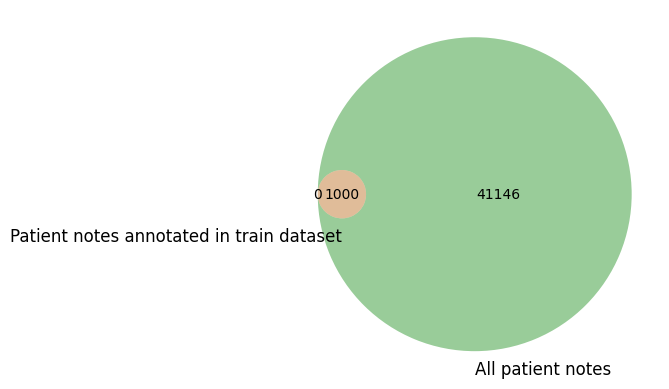

In [19]:
patient_notes_data, patient_notes_in_train_data = set(patient_notes_df['pn_num'].unique().tolist()), set(train_df['pn_num'].unique().tolist())
venn2((patient_notes_in_train_data, patient_notes_data), set_labels = ('Patient notes annotated in train dataset', 'All patient notes'))
plt.show()

In [20]:
# Number of features for each case

features_df.groupby(['case_num']).agg({'feature_num':'nunique'}).reset_index().sort_values(by = 'feature_num', ascending = False)

,case_num,feature_num
5,5,18
8,8,18
2,2,17
9,9,17
3,3,16
0,0,13
1,1,13
6,6,12
4,4,10
7,7,9


# Preprocess the data

## Correcting multiple classes numbers for same class

In [21]:
print("feature_nums corresponding to female: ", train_df[train_df['annotation'] == "['F']" ]['feature_num'].unique())
print("feature_nums corresponding to male: ", train_df[train_df['annotation'] == "['M']" ]['feature_num'].unique())
print("feature_nums corresponding to nausea: ", train_df[train_df['annotation'] == "['Nausea']" ]['feature_num'].unique())
print("feature_nums corresponding to 17-year old: ", train_df[train_df['annotation'] == "['17']" ]['feature_num'].unique())
print("feature_nums corresponding to 20-year old: ", train_df[train_df['annotation'] == "['20']" ]['feature_num'].unique())
print("feature_nums corresponding to 35-year old: ", train_df[train_df['annotation'] == "['35']" ]['feature_num'].unique())

feature_nums corresponding to female:  [112 208 407 501 700 802 913]
feature_nums corresponding to male:  [ 12 308 601]
feature_nums corresponding to nausea:  [314 908]
feature_nums corresponding to 17-year old:  [ 11 602]
feature_nums corresponding to 20-year old:  [104 901]
feature_nums corresponding to 35-year old:  [315 707]


In [22]:
# One Label only for each feature
# Female     ----->     112
# Male       ----->     12
# Nausea     ----->     314
# 17-year    ----->     11
# 20-year    ----->     104
# 35-year    ----->     315

replacement_dict = {208: 112, 407: 112, 501: 112, 700: 112, 802: 112, 913: 112,
                    308: 12, 601: 12,
                    908: 314,
                    602: 11,
                    901: 104,
                    707: 315
                    }

train_df['feature_num'] = train_df['feature_num'].replace(replacement_dict)

features_df['feature_num'] = features_df['feature_num'].replace(replacement_dict)
features_df = features_df.drop_duplicates(subset='feature_num', keep='first')

In [23]:
features_df.shape

(131, 3)

## Changing distribution of classes numbers

In [24]:
new_feature_labels = np.arange(131)
new_feature_labels = new_feature_labels * 2 + 1

new_feature_labels

array([  1,   3,   5,   7,   9,  11,  13,  15,  17,  19,  21,  23,  25,
        27,  29,  31,  33,  35,  37,  39,  41,  43,  45,  47,  49,  51,
        53,  55,  57,  59,  61,  63,  65,  67,  69,  71,  73,  75,  77,
        79,  81,  83,  85,  87,  89,  91,  93,  95,  97,  99, 101, 103,
       105, 107, 109, 111, 113, 115, 117, 119, 121, 123, 125, 127, 129,
       131, 133, 135, 137, 139, 141, 143, 145, 147, 149, 151, 153, 155,
       157, 159, 161, 163, 165, 167, 169, 171, 173, 175, 177, 179, 181,
       183, 185, 187, 189, 191, 193, 195, 197, 199, 201, 203, 205, 207,
       209, 211, 213, 215, 217, 219, 221, 223, 225, 227, 229, 231, 233,
       235, 237, 239, 241, 243, 245, 247, 249, 251, 253, 255, 257, 259,
       261])

In [25]:
features_map = {}

for i in range(len(new_feature_labels)):
  features_map[features_df.iloc[i,:]['feature_num']] = new_feature_labels[i]


features_map

{0: 1,
 1: 3,
 2: 5,
 3: 7,
 4: 9,
 5: 11,
 6: 13,
 7: 15,
 8: 17,
 9: 19,
 10: 21,
 11: 23,
 12: 25,
 100: 27,
 101: 29,
 102: 31,
 103: 33,
 104: 35,
 105: 37,
 106: 39,
 107: 41,
 108: 43,
 109: 45,
 110: 47,
 111: 49,
 112: 51,
 200: 53,
 201: 55,
 202: 57,
 203: 59,
 204: 61,
 205: 63,
 206: 65,
 207: 67,
 209: 69,
 210: 71,
 211: 73,
 212: 75,
 213: 77,
 214: 79,
 215: 81,
 216: 83,
 300: 85,
 301: 87,
 302: 89,
 303: 91,
 304: 93,
 305: 95,
 306: 97,
 307: 99,
 309: 101,
 310: 103,
 311: 105,
 312: 107,
 313: 109,
 314: 111,
 315: 113,
 400: 115,
 401: 117,
 402: 119,
 403: 121,
 404: 123,
 405: 125,
 406: 127,
 408: 129,
 409: 131,
 500: 133,
 502: 135,
 503: 137,
 504: 139,
 505: 141,
 506: 143,
 507: 145,
 508: 147,
 509: 149,
 510: 151,
 511: 153,
 512: 155,
 513: 157,
 514: 159,
 515: 161,
 516: 163,
 517: 165,
 600: 167,
 603: 169,
 604: 171,
 605: 173,
 606: 175,
 607: 177,
 608: 179,
 609: 181,
 610: 183,
 611: 185,
 701: 187,
 702: 189,
 703: 191,
 704: 193,
 705: 195,


In [26]:
# Apply changes to features_df

features_df['feature_num'] = features_df['feature_num'].replace(features_map)

display(features_df)

/tmp/ipykernel_42/3203790529.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,feature_num,case_num,feature_text
0,1,0,Family-history-of-MI-OR-Family-history-of-myoc...
1,3,0,Family-history-of-thyroid-disorder
2,5,0,Chest-pressure
3,7,0,Intermittent-symptoms
4,9,0,Lightheaded
...,...,...,...
137,253,9,Meningococcal-vaccine-status-unknown
138,255,9,Family-history-of-migraines
140,257,9,Photophobia
141,259,9,No-known-illness-contacts


In [27]:
# Apply changes to features_df

train_df['feature_num'] = train_df['feature_num'].replace(features_map)

display(train_df)

,id,case_num,pn_num,feature_num,annotation,location
0,00016_000,0,16,1,['dad with recent heart attcak'],['696 724']
1,00016_001,0,16,3,"['mom with ""thyroid disease']",['668 693']
2,00016_002,0,16,5,['chest pressure'],['203 217']
3,00016_003,0,16,7,"['intermittent episodes', 'episode']","['70 91', '176 183']"
4,00016_004,0,16,9,['felt as if he were going to pass out'],['222 258']
...,...,...,...,...,...,...
14295,95333_912,9,95333,255,[],[]
14296,95333_913,9,95333,51,[],[]
14297,95333_914,9,95333,257,['photobia'],['274 282']
14298,95333_915,9,95333,259,['no sick contacts'],['421 437']


## Correcting inconsistencies found in data


In [25]:
display(features_df.loc[27, 'feature_text'])
features_df.loc[27, 'feature_text'] = "Last-Pap-smear-1-year-ago"
display(features_df.loc[27, 'feature_text'])

'Last-Pap-smear-I-year-ago'

'Last-Pap-smear-1-year-ago'

## Correcting annotations

In [28]:
train_df['annotation'] = train_df['annotation'].apply(ast.literal_eval)
train_df['location'] = train_df['location'].apply(ast.literal_eval)

# those wrong annotations were stated

train_df.loc[338, 'annotation'] = ast.literal_eval('[["father heart attack"]]')
train_df.loc[338, 'location'] = ast.literal_eval('[["764 783"]]')

train_df.loc[621, 'annotation'] = ast.literal_eval('[["for the last 2-3 months"]]')
train_df.loc[621, 'location'] = ast.literal_eval('[["77 100"]]')

train_df.loc[655, 'annotation'] = ast.literal_eval('[["no heat intolerance"], ["no cold intolerance"]]')
train_df.loc[655, 'location'] = ast.literal_eval('[["285 292;301 312"], ["285 287;296 312"]]')

train_df.loc[1262, 'annotation'] = ast.literal_eval('[["mother thyroid problem"]]')
train_df.loc[1262, 'location'] = ast.literal_eval('[["551 557;565 580"]]')

train_df.loc[1265, 'annotation'] = ast.literal_eval('[[\'felt like he was going to "pass out"\']]')
train_df.loc[1265, 'location'] = ast.literal_eval('[["131 135;181 212"]]')

train_df.loc[1396, 'annotation'] = ast.literal_eval('[["stool , with no blood"]]')
train_df.loc[1396, 'location'] = ast.literal_eval('[["259 280"]]')

train_df.loc[1591, 'annotation'] = ast.literal_eval('[["diarrhoe non blooody"]]')
train_df.loc[1591, 'location'] = ast.literal_eval('[["176 184;201 212"]]')

train_df.loc[1615, 'annotation'] = ast.literal_eval('[["diarrhea for last 2-3 days"]]')
train_df.loc[1615, 'location'] = ast.literal_eval('[["249 257;271 288"]]')

train_df.loc[1664, 'annotation'] = ast.literal_eval('[["no vaginal discharge"]]')
train_df.loc[1664, 'location'] = ast.literal_eval('[["822 824;907 924"]]')

train_df.loc[1714, 'annotation'] = ast.literal_eval('[["started about 8-10 hours ago"]]')
train_df.loc[1714, 'location'] = ast.literal_eval('[["101 129"]]')

train_df.loc[1929, 'annotation'] = ast.literal_eval('[["no blood in the stool"]]')
train_df.loc[1929, 'location'] = ast.literal_eval('[["531 539;549 561"]]')

train_df.loc[2134, 'annotation'] = ast.literal_eval('[["last sexually active 9 months ago"]]')
train_df.loc[2134, 'location'] = ast.literal_eval('[["540 560;581 593"]]')

train_df.loc[2191, 'annotation'] = ast.literal_eval('[["right lower quadrant pain"]]')
train_df.loc[2191, 'location'] = ast.literal_eval('[["32 57"]]')

train_df.loc[2553, 'annotation'] = ast.literal_eval('[["diarrhoea no blood"]]')
train_df.loc[2553, 'location'] = ast.literal_eval('[["308 317;376 384"]]')

train_df.loc[3124, 'annotation'] = ast.literal_eval('[["sweating"]]')
train_df.loc[3124, 'location'] = ast.literal_eval('[["549 557"]]')

train_df.loc[3858, 'annotation'] = ast.literal_eval('[["previously as regular"], ["previously eveyr 28-29 days"], ["previously lasting 5 days"], ["previously regular flow"]]')
train_df.loc[3858, 'location'] = ast.literal_eval('[["102 123"], ["102 112;125 141"], ["102 112;143 157"], ["102 112;159 171"]]')

train_df.loc[4373, 'annotation'] = ast.literal_eval('[["for 2 months"]]')
train_df.loc[4373, 'location'] = ast.literal_eval('[["33 45"]]')

train_df.loc[4763, 'annotation'] = ast.literal_eval('[["35 year old"]]')
train_df.loc[4763, 'location'] = ast.literal_eval('[["5 16"]]')

train_df.loc[4782, 'annotation'] = ast.literal_eval('[["darker brown stools"]]')
train_df.loc[4782, 'location'] = ast.literal_eval('[["175 194"]]')

train_df.loc[4908, 'annotation'] = ast.literal_eval('[["uncle with peptic ulcer"]]')
train_df.loc[4908, 'location'] = ast.literal_eval('[["700 723"]]')

train_df.loc[6016, 'annotation'] = ast.literal_eval('[["difficulty falling asleep"]]')
train_df.loc[6016, 'location'] = ast.literal_eval('[["225 250"]]')

train_df.loc[6192, 'annotation'] = ast.literal_eval('[["helps to take care of aging mother and in-laws"]]')
train_df.loc[6192, 'location'] = ast.literal_eval('[["197 218;236 260"]]')

train_df.loc[6380, 'annotation'] = ast.literal_eval('[["No hair changes"], ["No skin changes"], ["No GI changes"], ["No palpitations"], ["No excessive sweating"]]')
train_df.loc[6380, 'location'] = ast.literal_eval('[["480 482;507 519"], ["480 482;499 503;512 519"], ["480 482;521 531"], ["480 482;533 545"], ["480 482;564 582"]]')

train_df.loc[6562, 'annotation'] = ast.literal_eval('[["stressed due to taking care of her mother"], ["stressed due to taking care of husbands parents"]]')
train_df.loc[6562, 'location'] = ast.literal_eval('[["290 320;327 337"], ["290 320;342 358"]]')

train_df.loc[6862, 'annotation'] = ast.literal_eval('[["stressor taking care of many sick family members"]]')
train_df.loc[6862, 'location'] = ast.literal_eval('[["288 296;324 363"]]')

train_df.loc[7022, 'annotation'] = ast.literal_eval('[["heart started racing and felt numbness for the 1st time in her finger tips"]]')
train_df.loc[7022, 'location'] = ast.literal_eval('[["108 182"]]')

train_df.loc[7422, 'annotation'] = ast.literal_eval('[["first started 5 yrs"]]')
train_df.loc[7422, 'location'] = ast.literal_eval('[["102 121"]]')

train_df.loc[8876, 'annotation'] = ast.literal_eval('[["No shortness of breath"]]')
train_df.loc[8876, 'location'] = ast.literal_eval('[["481 483;533 552"]]')

train_df.loc[9027, 'annotation'] = ast.literal_eval('[["recent URI"], ["nasal stuffines, rhinorrhea, for 3-4 days"]]')
train_df.loc[9027, 'location'] = ast.literal_eval('[["92 102"], ["123 164"]]')

train_df.loc[9938, 'annotation'] = ast.literal_eval('[["irregularity with her cycles"], ["heavier bleeding"], ["changes her pad every couple hours"]]')
train_df.loc[9938, 'location'] = ast.literal_eval('[["89 117"], ["122 138"], ["368 402"]]')

train_df.loc[9973, 'annotation'] = ast.literal_eval('[["gaining 10-15 lbs"]]')
train_df.loc[9973, 'location'] = ast.literal_eval('[["344 361"]]')

train_df.loc[10513, 'annotation'] = ast.literal_eval('[["weight gain"], ["gain of 10-16lbs"]]')
train_df.loc[10513, 'location'] = ast.literal_eval('[["600 611"], ["607 623"]]')

train_df.loc[11551, 'annotation'] = ast.literal_eval('[["seeing her son knows are not real"]]')
train_df.loc[11551, 'location'] = ast.literal_eval('[["386 400;443 461"]]')

train_df.loc[11677, 'annotation'] = ast.literal_eval('[["saw him once in the kitchen after he died"]]')
train_df.loc[11677, 'location'] = ast.literal_eval('[["160 201"]]')

train_df.loc[12124, 'annotation'] = ast.literal_eval('[["tried Ambien but it didnt work"]]')
train_df.loc[12124, 'location'] = ast.literal_eval('[["325 337;349 366"]]')

train_df.loc[12279, 'annotation'] = ast.literal_eval('[["heard what she described as a party later than evening these things did not actually happen"]]')
train_df.loc[12279, 'location'] = ast.literal_eval('[["405 459;488 524"]]')

train_df.loc[12289, 'annotation'] = ast.literal_eval('[["experienced seeing her son at the kitchen table these things did not actually happen"]]')
train_df.loc[12289, 'location'] = ast.literal_eval('[["353 400;488 524"]]')

train_df.loc[13238, 'annotation'] = ast.literal_eval('[["SCRACHY THROAT"], ["RUNNY NOSE"]]')
train_df.loc[13238, 'location'] = ast.literal_eval('[["293 307"], ["321 331"]]')

train_df.loc[13297, 'annotation'] = ast.literal_eval('[["without improvement when taking tylenol"], ["without improvement when taking ibuprofen"]]')
train_df.loc[13297, 'location'] = ast.literal_eval('[["182 221"], ["182 213;225 234"]]')

train_df.loc[13299, 'annotation'] = ast.literal_eval('[["yesterday"], ["yesterday"]]')
train_df.loc[13299, 'location'] = ast.literal_eval('[["79 88"], ["409 418"]]')

train_df.loc[13845, 'annotation'] = ast.literal_eval('[["headache global"], ["headache throughout her head"]]')
train_df.loc[13845, 'location'] = ast.literal_eval('[["86 94;230 236"], ["86 94;237 256"]]')

train_df.loc[14083, 'annotation'] = ast.literal_eval('[["headache generalized in her head"]]')
train_df.loc[14083, 'location'] = ast.literal_eval('[["56 64;156 179"]]')

## Merge the data

In [29]:
merged_df = pd.merge(train_df, patient_notes_df[['pn_num', 'pn_history']], on='pn_num', how='left')

display(merged_df)

,id,case_num,pn_num,feature_num,annotation,location,pn_history
0,00016_000,0,16,1,[dad with recent heart attcak],[696 724],HPI: 17yo M presents with palpitations. Patien...
1,00016_001,0,16,3,"[mom with ""thyroid disease]",[668 693],HPI: 17yo M presents with palpitations. Patien...
2,00016_002,0,16,5,[chest pressure],[203 217],HPI: 17yo M presents with palpitations. Patien...
3,00016_003,0,16,7,"[intermittent episodes, episode]","[70 91, 176 183]",HPI: 17yo M presents with palpitations. Patien...
4,00016_004,0,16,9,[felt as if he were going to pass out],[222 258],HPI: 17yo M presents with palpitations. Patien...
...,...,...,...,...,...,...,...
14295,95333_912,9,95333,255,[],[],Stephanie madden is a 20 year old woman compla...
14296,95333_913,9,95333,51,[],[],Stephanie madden is a 20 year old woman compla...
14297,95333_914,9,95333,257,[photobia],[274 282],Stephanie madden is a 20 year old woman compla...
14298,95333_915,9,95333,259,[no sick contacts],[421 437],Stephanie madden is a 20 year old woman compla...


In [30]:
merged_df.drop(['id',	'case_num', 'location'],axis=1,inplace=True)

display(merged_df)

,pn_num,feature_num,annotation,pn_history
0,16,1,[dad with recent heart attcak],HPI: 17yo M presents with palpitations. Patien...
1,16,3,"[mom with ""thyroid disease]",HPI: 17yo M presents with palpitations. Patien...
2,16,5,[chest pressure],HPI: 17yo M presents with palpitations. Patien...
3,16,7,"[intermittent episodes, episode]",HPI: 17yo M presents with palpitations. Patien...
4,16,9,[felt as if he were going to pass out],HPI: 17yo M presents with palpitations. Patien...
...,...,...,...,...
14295,95333,255,[],Stephanie madden is a 20 year old woman compla...
14296,95333,51,[],Stephanie madden is a 20 year old woman compla...
14297,95333,257,[photobia],Stephanie madden is a 20 year old woman compla...
14298,95333,259,[no sick contacts],Stephanie madden is a 20 year old woman compla...


In [31]:
merged_df.to_csv('your_file_name.csv', index=False)

## Tokenization

In [32]:
for i in range(len(merged_df)):

  merged_df.at[i,'pn_history'] = preprocess_text(merged_df.at[i,'pn_history'])
  merged_df.at[i,'pn_history'] = word_tokenize(merged_df.at[i,'pn_history'])

  merged_df.at[i,'annotation'] = [preprocess_text(sentence) for sentence in merged_df.at[i,'annotation']]
  merged_df.at[i,'annotation'] = [word_tokenize(sentence) for sentence in merged_df.at[i,'annotation']]

In [33]:
tokenized_pn_history = merged_df['pn_history']

In [34]:
merged_df

,pn_num,feature_num,annotation,pn_history
0,16,1,"[[dad, with, recent, heart, attcak]]","[hpi, 17yo, presents, with, palpitations, pati..."
1,16,3,"[[mom, with, thyroid, disease]]","[hpi, 17yo, presents, with, palpitations, pati..."
2,16,5,"[[chest, pressure]]","[hpi, 17yo, presents, with, palpitations, pati..."
3,16,7,"[[intermittent, episodes], [episode]]","[hpi, 17yo, presents, with, palpitations, pati..."
4,16,9,"[[felt, as, if, he, were, going, to, pass, out]]","[hpi, 17yo, presents, with, palpitations, pati..."
...,...,...,...,...
14295,95333,255,[],"[stephanie, madden, is, 20, year, old, woman, ..."
14296,95333,51,[],"[stephanie, madden, is, 20, year, old, woman, ..."
14297,95333,257,[[photobia]],"[stephanie, madden, is, 20, year, old, woman, ..."
14298,95333,259,"[[no, sick, contacts]]","[stephanie, madden, is, 20, year, old, woman, ..."


## Labeling

In [36]:
merged_labeled = merged_df
merged_labeled['labels'] = merged_labeled['pn_history'].apply(lambda x: [0]*len(x))

merged_labeled

,pn_num,feature_num,annotation,pn_history,labels
0,16,1,"[[dad, with, recent, heart, attcak]]","[hpi, 17yo, presents, with, palpitations, pati...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,16,3,"[[mom, with, thyroid, disease]]","[hpi, 17yo, presents, with, palpitations, pati...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,16,5,"[[chest, pressure]]","[hpi, 17yo, presents, with, palpitations, pati...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,16,7,"[[intermittent, episodes], [episode]]","[hpi, 17yo, presents, with, palpitations, pati...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,16,9,"[[felt, as, if, he, were, going, to, pass, out]]","[hpi, 17yo, presents, with, palpitations, pati...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...
14295,95333,255,[],"[stephanie, madden, is, 20, year, old, woman, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
14296,95333,51,[],"[stephanie, madden, is, 20, year, old, woman, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
14297,95333,257,[[photobia]],"[stephanie, madden, is, 20, year, old, woman, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
14298,95333,259,"[[no, sick, contacts]]","[stephanie, madden, is, 20, year, old, woman, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [37]:
for i in range(len(merged_df)):

  annotations = merged_labeled.at[i,'annotation']
  paragraph = merged_labeled.at[i,'pn_history']
  feature_num = merged_labeled.at[i,'feature_num']
  labels = merged_labeled.at[i,'labels']

  for annotation in annotations:
    merged_labeled.at[i,'labels'] = match_sentence(annotation, paragraph, feature_num, labels)

In [38]:
pn_num_to_labels = {}

unique_pn_num = list(set(merged_labeled['pn_num']))
unique_pn_num.sort()

for pn_num in unique_pn_num:
  labels_filtered = merged_labeled['labels'][merged_labeled['pn_num'] == pn_num]

  if labels_filtered.empty or len(labels_filtered.iloc[0]) == 0:
    continue

  pn_num_to_labels[pn_num] = [0]*len(labels_filtered.iloc[0])

  for labels_list in merged_labeled['labels'][merged_labeled['pn_num'] == pn_num]:
    pn_num_to_labels[pn_num] = or_on_list(labels_list,pn_num_to_labels[pn_num])

In [39]:
# Assuming pn_history is a column in patient_notes_df and represents the length needed

patient_notes_df['labels'] = patient_notes_df.apply(lambda row: get_labels(pn_num_to_labels, row['pn_num']), axis=1)

patient_notes_df = patient_notes_df[patient_notes_df['labels'].apply(lambda x: len(x) > 0)]

patient_notes_df = patient_notes_df.reset_index()

patient_notes_df

,index,pn_num,case_num,pn_history,pn_history length,labels
0,16,16,0,HPI: 17yo M presents with palpitations. Patien...,142,"[0, 23, 0, 0, 19, 0, 0, 21, 22, 22, 22, 7, 8, ..."
1,40,41,0,17 Y/O M CAME TO THE CLINIC C/O HEART POUNDING...,113,"[23, 24, 0, 0, 0, 0, 0, 19, 20, 21, 22, 22, 22..."
2,45,46,0,Mr. Cleveland is a 17yo M who was consented by...,155,"[0, 0, 0, 23, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,79,82,0,17 yo M w/ no cardiac or arrhythmia PMH presen...,152,"[23, 24, 0, 0, 0, 0, 0, 0, 0, 0, 0, 21, 22, 22..."
4,96,100,0,HPI: Dillon Cleveland is an otherwise healthy ...,111,"[0, 0, 0, 0, 0, 0, 0, 23, 24, 24, 25, 0, 0, 0,..."
...,...,...,...,...,...,...
995,41963,95145,9,Pt is 20 yo F w headache since yesterday morni...,109,"[0, 0, 35, 36, 0, 0, 0, 237, 0, 0, 0, 0, 0, 0,..."
996,42042,95228,9,"20 F no PMH, lives w/ roommate in apartment ha...",34,"[35, 0, 0, 251, 252, 252, 252, 0, 0, 0, 0, 257..."
997,42056,95243,9,20 y/o F with no PMH is presenting with 1 day ...,108,"[35, 36, 0, 0, 0, 0, 0, 0, 237, 238, 0, 0, 0, ..."
998,42141,95330,9,Ms. Madden is a 20 yo female presenting w/ the...,136,"[51, 0, 0, 35, 36, 51, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [40]:
for i in range(len(patient_notes_df)):
  patient_notes_df.at[i,'pn_history'] = preprocess_text(patient_notes_df.at[i,'pn_history'])
  patient_notes_df.at[i,'pn_history'] = word_tokenize(patient_notes_df.at[i,'pn_history'])

patient_notes_df.rename(columns={'pn_history': 'tokens', 'labels': 'ner_tags'}, inplace=True)
patient_notes_df

,index,pn_num,case_num,tokens,pn_history length,ner_tags
0,16,16,0,"[hpi, 17yo, presents, with, palpitations, pati...",142,"[0, 23, 0, 0, 19, 0, 0, 21, 22, 22, 22, 7, 8, ..."
1,40,41,0,"[17, o, came, to, the, clinic, o, heart, pound...",113,"[23, 24, 0, 0, 0, 0, 0, 19, 20, 21, 22, 22, 22..."
2,45,46,0,"[mr, cleveland, is, 17yo, who, was, consented,...",155,"[0, 0, 0, 23, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,79,82,0,"[17, yo, w, no, cardiac, or, arrhythmia, pmh, ...",152,"[23, 24, 0, 0, 0, 0, 0, 0, 0, 0, 0, 21, 22, 22..."
4,96,100,0,"[hpi, dillon, cleveland, is, an, otherwise, he...",111,"[0, 0, 0, 0, 0, 0, 0, 23, 24, 24, 25, 0, 0, 0,..."
...,...,...,...,...,...,...
995,41963,95145,9,"[pt, is, 20, yo, w, headache, since, yesterday...",109,"[0, 0, 35, 36, 0, 0, 0, 237, 0, 0, 0, 0, 0, 0,..."
996,42042,95228,9,"[20, no, pmh, lives, roommate, in, apartment, ...",34,"[35, 0, 0, 251, 252, 252, 252, 0, 0, 0, 0, 257..."
997,42056,95243,9,"[20, o, with, no, pmh, is, presenting, with, 1...",108,"[35, 36, 0, 0, 0, 0, 0, 0, 237, 238, 0, 0, 0, ..."
998,42141,95330,9,"[ms, madden, is, 20, yo, female, presenting, t...",136,"[51, 0, 0, 35, 36, 51, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [41]:
# Shuffle the data
patient_notes_df = patient_notes_df.sample(frac=1, random_state=42).reset_index(drop=True)

patient_notes_df

,index,pn_num,case_num,tokens,pn_history length,ner_tags
0,21678,51533,5,"[edie, whelan, 26, year, old, female, has, com...",118,"[0, 0, 165, 166, 166, 51, 0, 0, 0, 0, 0, 0, 0,..."
1,30280,71649,7,"[35, year, old, female, with, 6, month, histor...",160,"[113, 114, 114, 51, 0, 199, 200, 0, 0, 0, 189,..."
2,30352,71724,7,"[35, yo, with, heavy, periods, for, the, past,...",114,"[113, 114, 0, 189, 190, 0, 0, 0, 199, 200, 0, ..."
3,28023,61018,6,"[kane, smith, 17, year, old, male, has, come, ...",69,"[0, 0, 23, 24, 24, 25, 0, 0, 0, 0, 0, 0, 0, 17..."
4,15725,40974,4,"[45, yo, female, presents, with, complaints, o...",132,"[131, 132, 51, 0, 0, 0, 0, 117, 0, 0, 0, 0, 0,..."
...,...,...,...,...,...,...
995,2305,10044,1,"[hpi, 20, f, complains, of, sudden, onset, rig...",156,"[0, 0, 51, 0, 0, 0, 0, 41, 42, 42, 49, 50, 50,..."
996,4560,21621,2,"[44, yo, female, o, irregular, menstruation, 3...",114,"[83, 84, 51, 0, 63, 64, 0, 0, 0, 0, 0, 0, 0, 0..."
997,35202,82515,8,"[loraine, wicks, 67yo, with, pmh, htn, on, hct...",159,"[0, 0, 209, 0, 0, 0, 0, 0, 0, 0, 0, 0, 215, 21..."
998,16977,42262,4,"[ms, moore, is, 45, yo, female, who, presents,...",70,"[0, 0, 0, 131, 132, 51, 0, 0, 0, 117, 0, 0, 0,..."


# Fine tuning and Training

In [42]:
label_names = features_df['feature_text']
label_names

0      Family-history-of-MI-OR-Family-history-of-myoc...
1                     Family-history-of-thyroid-disorder
2                                         Chest-pressure
3                                  Intermittent-symptoms
4                                            Lightheaded
                             ...                        
137                 Meningococcal-vaccine-status-unknown
138                          Family-history-of-migraines
140                                          Photophobia
141                            No-known-illness-contacts
142                                     Subjective-fever
Name: feature_text, Length: 131, dtype: object

In [43]:
label_names_adjusted = ['O']

for label_name in label_names:
  label_names_adjusted.append('B-' + label_name)
  label_names_adjusted.append('I-'+label_name)
label_names_adjusted
label_names = label_names_adjusted

In [44]:
dataset = Dataset.from_pandas(patient_notes_df)
dataset

Dataset({
    features: ['index', 'pn_num', 'case_num', 'tokens', 'pn_history length', 'ner_tags'],
    num_rows: 1000
})

In [45]:
# Convert DataFrame to Dataset object
dataset = Dataset.from_pandas(patient_notes_df)

# Split the dataset into train and validation subsets using scikit-learn
train_ratio = 0.8  # Ratio of the dataset to use for training
train_data, validation_data = train_test_split(dataset, test_size=1 - train_ratio)

# Create datasets with 'train' and 'validation' keys
dataset_dict = {
    'train': Dataset.from_pandas(pd.DataFrame(train_data)),
    'validation': Dataset.from_pandas(pd.DataFrame(validation_data))
}

In [46]:
#Get the values for input_ids, attention_mask, adjusted labels

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")


def tokenize_adjust_labels(all_samples_per_split):
  tokenized_samples = tokenizer.batch_encode_plus(all_samples_per_split["tokens"], is_split_into_words=True, truncation=True)

  total_adjusted_labels = []

  for k in range(0, len(tokenized_samples["input_ids"])):
    prev_wid = -1
    word_ids_list = tokenized_samples.word_ids(batch_index=k)
    existing_label_ids = all_samples_per_split["ner_tags"][k]
    i = -1
    adjusted_label_ids = []

    for word_idx in word_ids_list:
      # Special tokens have a word id that is None. We set the label to -100 so they are automatically
      # ignored in the loss function.
      if(word_idx is None):
        adjusted_label_ids.append(-100)
      elif(word_idx!=prev_wid):
        i = i + 1
        adjusted_label_ids.append(existing_label_ids[i])
        prev_wid = word_idx
      else:
        label_name = label_names[existing_label_ids[i]]
        adjusted_label_ids.append(existing_label_ids[i])

    total_adjusted_labels.append(adjusted_label_ids)

  #add adjusted labels to the tokenized samples
  tokenized_samples["labels"] = total_adjusted_labels
  return tokenized_samples

# tokenized_dataset = dataset_dict.map(tokenize_adjust_labels, batched=True, remove_columns=['tokens', 'ner_tags', 'pn_num', 'case_num'])
tokenized_train = dataset_dict['train'].map(tokenize_adjust_labels, batched=True, remove_columns=['tokens', 'ner_tags', 'pn_num', 'case_num'])
tokenized_validation = dataset_dict['validation'].map(tokenize_adjust_labels, batched=True, remove_columns=['tokens', 'ner_tags', 'pn_num', 'case_num'])
tokenized_dataset = dataset.map(tokenize_adjust_labels, batched=True, remove_columns=['tokens', 'ner_tags', 'pn_num', 'case_num'])

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [47]:
data_collator = DataCollatorForTokenClassification(tokenizer)

data_collator

DataCollatorForTokenClassification(tokenizer=DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}, padding=True, max_length=None, pad_to_multiple_of=None, label_pad_tok

In [48]:
#check if gpu is present
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

- We will use Distillbert-base-uncased model for fine tuning
- We need to specify the number of labels present in the dataset

In [49]:
# Set up pretraining
pretrain_config = DistilBertConfig.from_pretrained("distilbert-base-uncased")
pretrain_model = DistilBertForMaskedLM(pretrain_config)
pretrain_tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Define large corpus for pretraining
corpus_files = ["/content/unlabeled_text.txt"]  # paths to unlabeled data files

# Initialize the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Define the maximum sequence length
block_size = 128  # Adjust this based on your requirements

# Create a LineByLineTextDataset for pretraining
pretrain_dataset = LineByLineTextDataset(
    tokenizer=tokenizer,
    file_path="/kaggle/input/unlabeled-text-txt/unlabeled_text.txt",
    block_size=block_size,
)
# Define pretraining training arguments

pretraining_args = TrainingArguments(
    output_dir="./pretrained_model",
    overwrite_output_dir=True,
    num_train_epochs=6,
    per_device_train_batch_size=32,
    logging_dir="./logs",
    logging_steps=500,
    save_steps=1000,
    save_total_limit=2,
    prediction_loss_only=True,
    learning_rate=1e-4
)

# Create a Trainer for pretraining
pretrainer = Trainer(
    model=pretrain_model,
    args=pretraining_args,
    data_collator=DataCollatorForLanguageModeling(tokenizer=pretrain_tokenizer, mlm=True),
    train_dataset=pretrain_dataset,
    tokenizer=pretrain_tokenizer
)

# Start pretraining
pretrainer.train()

# After pretraining, save the model weights
pretrain_model.save_pretrained("./pretrained_model")

# API Key: 5f7d60cb23d20c068e802b7a4ff1437ec79bfbff

/opt/conda/lib/python3.10/site-packages/transformers/data/datasets/language_modeling.py:119: FutureWarning:

This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss
500,5.777400
1000,4.811900
1500,4.383600
2000,3.951100
2500,3.547200
3000,2.954900
3500,2.539000
4000,2.379500
4500,2.197000
5000,2.095500


In [50]:
# Save the model file
zip_dir()

/kaggle/working/directory2.zip

In [51]:
# os.chdir('pretrained_model')
!ls

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


directory2.zip	logs  pretrained_model	wandb  your_file_name.csv


In [67]:
model = AutoModelForTokenClassification.from_pretrained("/kaggle/working/pretrained_model", num_labels=len(label_names))
model.to(device)

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at /kaggle/working/pretrained_model and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForTokenClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
    

- Create a function to generate metrics
- We will use `seqeval` metrics, commonly used for token classification

In [68]:
metric = load_metric("seqeval")

def compute_metrics(p):
    predictions, labels = p

    #select predicted index with maximum logit for each token
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_names[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [69]:
example = dataset[1]
labels = [label_names[i] for i in example[f"ner_tags"]]
metric.compute(predictions=[labels], references=[labels])

{'35-year': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 1},
 'Fatigue': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 1},
 'Female': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 1},
 'Unprotected-Sex': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 1},
 'Weight-Gain': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 1},
 'heavy-periods-OR-irregular-periods': {'precision': 1.0,
  'recall': 1.0,
  'f1': 1.0,
  'number': 2},
 'symptoms-for-6-months': {'precision': 1.0,
  'recall': 1.0,
  'f1': 1.0,
  'number': 3},
 'overall_precision': 1.0,
 'overall_recall': 1.0,
 'overall_f1': 1.0,
 'overall_accuracy': 1.0}

- Fine Tuning using Trainer API

In [70]:
batch_size = 16
logging_steps = len(tokenized_train) // batch_size
epochs = 15


# Convert the dataset into a list
tokenized_dataset = list(tokenized_dataset)


num_folds = 5
kf = KFold(n_splits=num_folds)

# Initialize lists to store evaluation results from each fold
eval_results = []

for fold, (train_index, val_index) in enumerate(kf.split(tokenized_dataset)):
    print(f"Training fold {fold + 1}/{num_folds}")

    # Split the dataset into train and validation sets for this fold
    tokenized_train_fold = [tokenized_dataset[i] for i in train_index]
    tokenized_validation_fold = [tokenized_dataset[i] for i in val_index]

    logging_steps = len(tokenized_train_fold) // batch_size

    learning_rate = 1e-3

    training_args = TrainingArguments(
        output_dir=f"/content/drive/MyDrive/bert-fine-tune-ner/results_fold_{fold}",
        num_train_epochs=epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        evaluation_strategy="epoch",
        disable_tqdm=False,
        logging_steps=logging_steps,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train_fold,
        eval_dataset=tokenized_validation_fold,
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    # Train the model on this fold
    trainer.train()

    # Evaluate the model on the validation set for this fold
    eval_result = trainer.evaluate(eval_dataset=tokenized_validation_fold)
    eval_results.append(eval_result)

# Average the evaluation metrics across folds
average_eval_results = {}
for metric in eval_results[0].keys():
    metric_sum = sum(result[metric] for result in eval_results)
    average_eval_results[metric] = metric_sum / num_folds

print("Average evaluation results across all folds:")
print(average_eval_results)


Training fold 1/5


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.689300,1.064307,0.357071,0.133784,0.194642,0.817893
2,0.811900,0.657018,0.495977,0.393837,0.439045,0.862324
3,0.532700,0.510288,0.524934,0.526118,0.525526,0.879250
4,0.404800,0.455262,0.564376,0.537016,0.550356,0.884510
5,0.323600,0.416051,0.547651,0.613303,0.578621,0.890373
6,0.267800,0.394671,0.553199,0.627208,0.587883,0.894423
7,0.223800,0.399119,0.558667,0.629838,0.592122,0.893668
8,0.190700,0.394321,0.570618,0.642240,0.604314,0.896539
9,0.163500,0.408393,0.568758,0.640361,0.602439,0.896690
10,0.145100,0.418573,0.578289,0.642616,0.608758,0.898111


/opt/conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

Checkpoint destination directory /content/drive/MyDrive/bert-fine-tune-ner/results_fold_0/checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Training fold 2/5


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.209100,0.113477,0.758632,0.847539,0.800625,0.968775
2,0.153100,0.108518,0.771311,0.827700,0.798511,0.968025
3,0.121800,0.100520,0.778423,0.837619,0.806937,0.970185
4,0.099400,0.102595,0.765358,0.837619,0.799860,0.968685
5,0.079200,0.097703,0.769282,0.846436,0.806017,0.970545
6,0.069300,0.105165,0.761322,0.846069,0.801462,0.968535
7,0.059300,0.100997,0.786011,0.833946,0.809269,0.969555
8,0.053000,0.102821,0.772347,0.847539,0.808198,0.968835
9,0.046700,0.103200,0.769179,0.839824,0.802950,0.968055
10,0.042900,0.106221,0.763158,0.841661,0.800489,0.968115


/opt/conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

Checkpoint destination directory /content/drive/MyDrive/bert-fine-tune-ner/results_fold_1/checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Training fold 3/5


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.079800,0.026774,0.935236,0.963438,0.949127,0.993605
2,0.055900,0.024467,0.932486,0.968338,0.950074,0.993815
3,0.044200,0.023789,0.926304,0.957030,0.941416,0.993184
4,0.037900,0.024386,0.923747,0.958914,0.941002,0.993034
5,0.031100,0.023423,0.922408,0.958914,0.940307,0.993064
6,0.026000,0.023007,0.922548,0.960799,0.941285,0.993034
7,0.022800,0.022083,0.922408,0.958914,0.940307,0.993154
8,0.019900,0.024147,0.920173,0.964568,0.941848,0.992614
9,0.018700,0.022846,0.921157,0.960045,0.940199,0.992884
10,0.016100,0.021840,0.921988,0.957784,0.939545,0.993214


/opt/conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

Checkpoint destination directory /content/drive/MyDrive/bert-fine-tune-ner/results_fold_2/checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



Training fold 4/5


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.032600,0.006237,0.987689,0.994800,0.991232,0.998869
2,0.025900,0.007373,0.986117,0.994400,0.990241,0.998624
3,0.022000,0.007091,0.986111,0.994000,0.990040,0.998685
4,0.018100,0.006043,0.986905,0.994800,0.990837,0.998899
5,0.016000,0.007487,0.979842,0.991600,0.985686,0.998318
6,0.012700,0.005208,0.990434,0.994000,0.992214,0.999174
7,0.010600,0.005337,0.988469,0.994400,0.991426,0.999052
8,0.008200,0.004803,0.988455,0.993200,0.990822,0.999022
9,0.007500,0.004937,0.984512,0.991600,0.988043,0.998838
10,0.007100,0.004831,0.985674,0.990800,0.988231,0.998899


Checkpoint destination directory /content/drive/MyDrive/bert-fine-tune-ner/results_fold_3/checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


Training fold 5/5


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.016000,0.002304,0.998526,0.999262,0.998894,0.999789
2,0.015200,0.002385,0.998525,0.998893,0.998709,0.999728
3,0.012200,0.002287,0.994847,0.997049,0.995947,0.999638
4,0.008800,0.002288,0.995215,0.997418,0.996315,0.999638
5,0.007400,0.001867,0.998894,0.999262,0.999078,0.999819
6,0.005900,0.001583,0.999263,0.999631,0.999447,0.999819
7,0.005000,0.001667,0.996683,0.997418,0.997050,0.999698
8,0.005100,0.001544,0.998526,0.999262,0.998894,0.999849
9,0.004200,0.001340,0.998526,0.999262,0.998894,0.999819
10,0.003700,0.001587,0.997422,0.998893,0.998157,0.999698


Checkpoint destination directory /content/drive/MyDrive/bert-fine-tune-ner/results_fold_4/checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


Average evaluation results across all folds:
{'eval_loss': 0.1155327561777085, 'eval_precision': 0.8502314306889873, 'eval_recall': 0.889126116636489, 'eval_f1': 0.8687357435243657, 'eval_accuracy': 0.9721020832675367, 'eval_runtime': 1.8642799999999997, 'eval_samples_per_second': 107.28599999999999, 'eval_steps_per_second': 6.9736, 'epoch': 15.0}


Our final Precision = 0.85, Recall = 0.889, F1-Score = 0.869 and Accuracy = 0.972

In [96]:
model.save_pretrained("./final_model")